In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import  RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
from IPython.display import display

In [3]:
data = pd.read_csv('./../data/raw/conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284580 entries, 0 to 284579
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              284580 non-null  object
 1   age                  284580 non-null  int64 
 2   new_user             284580 non-null  int64 
 3   source               284580 non-null  object
 4   total_pages_visited  284580 non-null  int64 
 5   converted            284580 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 13.0+ MB


* 0 missing values

In [5]:
data.describe()

,age,new_user,total_pages_visited,converted
count,284580.000000,284580.000000,284580.000000,284580.000000
mean,30.564203,0.685452,4.873252,0.032258
std,8.266789,0.464336,3.341995,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


* In average, 4 pages are visited per user \n
* 75 % of all users have visited less than 7 pages

In [6]:
data['converted'].value_counts()*100/data.shape[0]

0    96.774194
1     3.225806
Name: converted, dtype: float64

<b> /!\ From all users, there are 3% converted users </b>

Text(0, 0.5, 'total pages visited')

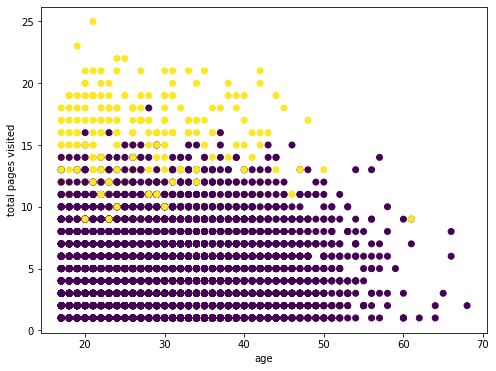

In [7]:
plt.figure(figsize=(8,6))
data_sample = data.sample(10000)
plt.scatter(data_sample['age'], data_sample['total_pages_visited'], c=data_sample['converted'])
plt.xlabel('age')
plt.ylabel('total pages visited')

In [8]:
import seaborn as sns

<AxesSubplot:xlabel='total_pages_visited', ylabel='age'>

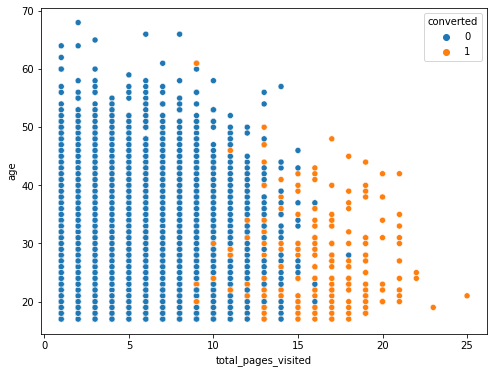

In [9]:
plt.figure(figsize=(8,6))
sns.scatterplot(y='age',x='total_pages_visited', hue='converted', data=data_sample)

<AxesSubplot:xlabel='total_pages_visited', ylabel='new_user'>

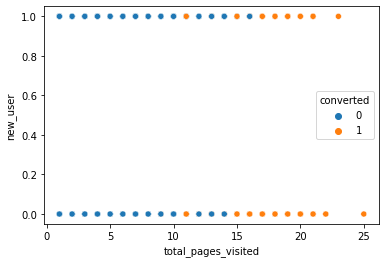

In [10]:
sns.scatterplot(y='new_user',x='total_pages_visited', hue='converted', data=data_sample)

It seems that the variable total_pages_visited has an important impact in the conversion rate
- From the graphics above, users having visited more than 15 pages have been coverted


<AxesSubplot:xlabel='country', ylabel='total_pages_visited'>

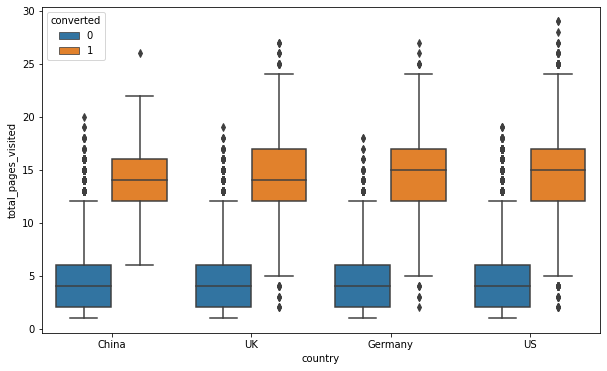

In [11]:
plt.figure(figsize=(10,6))
sns.boxplot(x='country', y='total_pages_visited', hue='converted',data=data)

Germany and US after visited more than 15 pages have been converted. 
China and UK with less than 15 pages visited were converted

<AxesSubplot:xlabel='country', ylabel='age'>

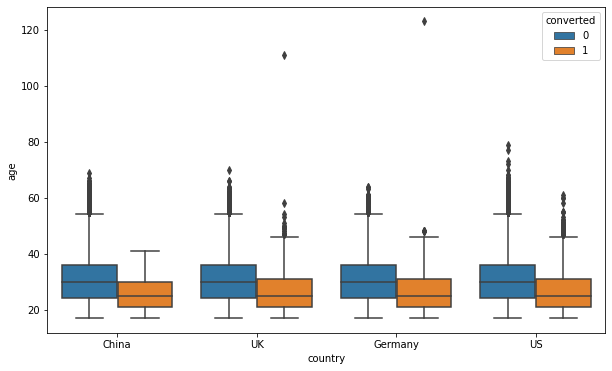

In [12]:
plt.figure(figsize=(10,6))
sns.boxplot(x='country', y='age', hue='converted',data=data)

In [13]:
def describe_per_country(data):
    grouped = data.groupby(['country']).describe()
    print('**total_pages_visited**')
    print(grouped['total_pages_visited'])
    print('\n')
    print('**age**')
    print(grouped['age'])

In [14]:
describe_per_country(data)

**total_pages_visited**
            count      mean       std  min  25%  50%  75%   max
country                                                        
China     69122.0  4.551604  2.805554  1.0  2.0  4.0  6.0  26.0
Germany   11693.0  5.207646  3.782125  1.0  2.0  4.0  7.0  27.0
UK        43641.0  5.078985  3.628525  1.0  2.0  4.0  7.0  27.0
US       160124.0  4.931609  3.428069  1.0  2.0  4.0  7.0  29.0


**age**
            count       mean       std   min   25%   50%   75%    max
country                                                              
China     69122.0  30.664014  8.275166  17.0  24.0  30.0  36.0   69.0
Germany   11693.0  30.457966  8.293478  17.0  24.0  30.0  36.0  123.0
UK        43641.0  30.433675  8.239715  17.0  24.0  30.0  36.0  111.0
US       160124.0  30.564450  8.268073  17.0  24.0  30.0  36.0   79.0


<AxesSubplot:xlabel='converted', ylabel='age'>

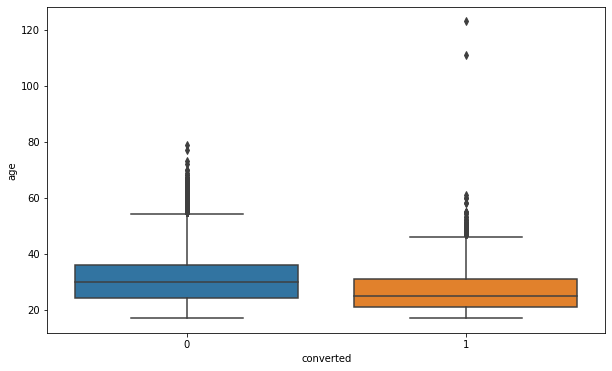

In [15]:
plt.figure(figsize=(10,6))
sns.boxplot(x='converted', y='age', data=data)

In [16]:
data[data['age']>60].count()*100/data.shape[0]

country                0.072739
age                    0.072739
new_user               0.072739
source                 0.072739
total_pages_visited    0.072739
converted              0.072739
dtype: float64

In [17]:
num_attributes = ['total_pages_visited']
target_label = ['converted']
X = data.drop(target_label, axis=1)[num_attributes]
y = data.loc[:, target_label]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [18]:
# Verifying we have the same proportion of conversion rates than original dataset
y.value_counts()*100/y.shape[0]

converted
0            96.774194
1             3.225806
dtype: float64

### LogisticRegression with default parameters

In [19]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train.values.ravel())
log_reg.score(X_train, y_train)

0.9829121612802827

In [20]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_train, log_reg.predict(X_train))
print(type(conf_matrix))
conf_matrix

<class 'numpy.ndarray'>


array([[191935,    859],
       [  2545,   3867]])

In [21]:
def labels_conf_matrix(conf_matrix):
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in conf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    return labels

In [22]:
labels =labels_conf_matrix(conf_matrix)

### Confusion matrix

<AxesSubplot:>

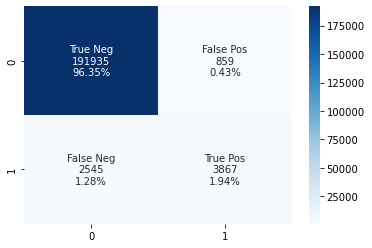

In [23]:
sns.heatmap(conf_matrix, annot=labels,fmt='', cmap='Blues')

### Metrics: precision, recall, f1

In [26]:
def predict_compare(model, X, y_true):
    y_pred = model.predict(X)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return precision, recall, f1

In [27]:
p, r, f1 = predict_compare(log_reg, X_train, y_train)
print('**Train***')
print('Precision={}'.format(p))
print('Recall={}'.format(r))
print('f1_score={}'.format(f1))
p, r, f1 = predict_compare(log_reg, X_test, y_test)
print('**Test***')
print('Precision={}'.format(p))
print('Recall={}'.format(r))
print('f1_score={}'.format(f1))


**Train***
Precision=0.8182395260262378
Recall=0.6030879600748597
f1_score=0.6943796013646976
**Test***
Precision=0.8301698301698301
Recall=0.6004335260115607
f1_score=0.6968553459119496


In [28]:
log_reg.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

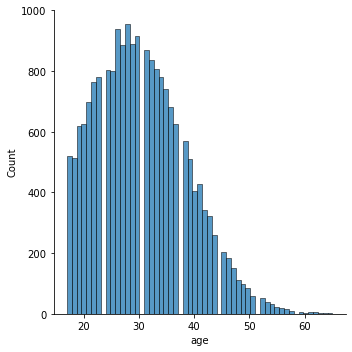

In [20]:
sns.displot(data.sample(20000), x="age")

## Cleaning


### Remove outliers

In [22]:
data[data['age']>70].index
data = data.drop(index=data[data['age']>60].index, axis=0)


In [38]:
data['age'].value_counts().sort_values(ascending=False)[0:10]

28    12972
30    12956
29    12710
27    12668
26    12525
31    12327
25    12157
32    12111
24    11647
33    11392
Name: age, dtype: int64

Top 10 ages in the dataset: 24 - 33 years old

In [48]:
data[data['converted'] == 1][['country']].value_counts().sort_values(ascending=False)
(data.groupby('country')['country'].count()*100/data.shape[0]).sort_values(ascending=False)

country
US         56.264484
China      24.289226
UK         15.337602
Germany     4.108688
Name: country, dtype: float64

<b> Proportion of users converted by country</b>

In [83]:
data.groupby(['country'])['converted'].agg('sum') * 100 /data['converted'].sum()

country
China       0.969816
Germany     7.943772
UK         24.953689
US         66.132723
Name: converted, dtype: float64

<b> Conversion rate per country: converted / visitors </b>

In [84]:
data.groupby(['country'])['converted'].agg('sum') * 100 /data.groupby(['country'])['converted'].count()

country
China      0.128851
Germany    6.239302
UK         5.250367
US         3.793101
Name: converted, dtype: float64

## Pre-processing pipeline

### Re-split data with all features

All features <br>
Test_set ratio : 20% 

In [99]:
target_label = ['converted']
X = data.drop(target_label, axis=1)
y = data[target_label].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Create transformation pipeline

In [39]:
num_features = X_train.select_dtypes(include=np.number).columns.to_list()
cat_features = X_train.select_dtypes(include=object).columns.to_list()
# Transformer for extra features from Date
# transformer for numerical features
num_transformer = Pipeline([
        ('imputer_num', SimpleImputer(strategy = 'median')),
        ('scaler', StandardScaler())
    ])
# transformer for categorical features
cat_transformer = Pipeline([
        ('imputer_cat', SimpleImputer(strategy = 'most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer([
        ('categoricals', cat_transformer, cat_features),
        ('numericals', num_transformer, num_features)
    ],
    remainder = 'drop'
)

In [40]:
classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(5),
    LinearSVC(),
    #NuSVC(probability=True),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    XGBClassifier(),
    #GradientBoostingClassifier()
    ]


### Train models to pick 1-3 best performances

In [41]:
headers = ['classifier', 'train_precision', 'train_recall', 'train_f1','test_precision', 'test_recall', 'test_f1']
values = list()
res_pipelines = list()
for classifier in classifiers:
    pipe = Pipeline(steps=[('preprocessing', preprocessor),
                      ('classifier', classifier)])
    pipe.fit(X_train, y_train.values.ravel())
    
    p, r, f1 = predict_compare(pipe, X_train, y_train.values.ravel())
    p_test, r_test, f1_test = predict_compare(pipe, X_test, y_test.values.ravel())
    values.append([str(classifier), p, r, f1, p_test, r_test, f1_test])
    #print("model score: %.3f" % pipe.score(X_test, y_test))   
    
#print(values)
clf_perf = pd.DataFrame(values, columns=headers)
clf_perf

/home/carmina/miniconda3/envs/pez-jedha/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/carmina/miniconda3/envs/pez-jedha/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:14:34] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,classifier,train_precision,train_recall,train_f1,test_precision,test_recall,test_f1
0,LogisticRegression(),0.857994,0.688200,0.763774,0.847113,0.694833,0.763454
1,LinearSVC(),0.869088,0.670036,0.756690,0.861073,0.673843,0.756039
2,RandomForestClassifier(),0.892452,0.729855,0.803005,0.803526,0.686760,0.740569
3,AdaBoostClassifier(),0.849975,0.684786,0.758490,0.847167,0.692142,0.761848
4,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.862616,0.698033,0.771646,0.838014,0.690527,0.757156


### Feature importances from RandomForest classifier

In [42]:
cat_encoder_attribs = np.asarray(pipe.named_steps['preprocessing'].named_transformers_['categoricals'].named_steps['onehot'].categories_, dtype=object)

In [43]:
cat_attribs = np.concatenate([cat_list for cat_list in cat_encoder_attribs])

In [44]:
all_features = np.concatenate([cat_attribs, num_features])
all_features

array(['China', 'Germany', 'UK', 'US', 'Ads', 'Direct', 'Seo', 'age',
       'new_user', 'total_pages_visited'], dtype=object)

In [ ]:
pipe.named_steps['preprocessing']

In [45]:
sorted(zip(pipe.steps[1][1].feature_importances_, all_features), reverse=True)

[(0.6110039, 'total_pages_visited'),
 (0.1650179, 'China'),
 (0.13887408, 'new_user'),
 (0.020104991, 'US'),
 (0.017243225, 'age'),
 (0.010911038, 'Direct'),
 (0.010494949, 'Germany'),
 (0.01023513, 'UK'),
 (0.008662763, 'Ads'),
 (0.0074520144, 'Seo')]

### SearchCV to find best parameters for RandomForestClassifier

In [50]:
ran_forest = Pipeline(steps=[('preprocessing', preprocessor),
                      ('classifier', RandomForestClassifier())])
param_grid = { 
    'classifier__n_estimators': [10, 100, 400],
    #'classifier__max_features': ['auto', 'sqrt', 'log2'],
    'classifier__max_depth' : [6,10,12],
    #'classifier__criterion' :['gini', 'entropy']
}

from sklearn.model_selection import GridSearchCV
CV = GridSearchCV(ran_forest, param_grid, n_jobs= 4, cv=3)
                  
CV.fit(X_train, y_train.values.ravel())  
print(CV.best_params_)    
print(CV.best_score_)
CV.score(X_test, y_test.values.ravel())


{'classifier__max_depth': 10, 'classifier__n_estimators': 400}
0.9859793379717479


0.9855225244219552

In [51]:
print(CV.score(X_test, y_test.values.ravel()))

0.9855225244219552


In [53]:
print(f1_score(y_test, CV.predict(X_test)))

0.7540298507462686

In [47]:
X_test

,country,age,new_user,source,total_pages_visited
256001,China,28,0,Direct,3
97792,US,19,0,Seo,1
121376,US,28,1,Seo,5
272924,US,22,1,Ads,7
239529,UK,27,1,Seo,7
...,...,...,...,...,...
204144,US,33,0,Ads,1
172953,US,27,1,Ads,2
161581,China,29,0,Seo,1
173040,UK,29,1,Seo,1


In [57]:
ran_forest.named_steps['classifier'].get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [58]:
ran_forest = Pipeline(steps=[('preprocessing', preprocessor),
                      ('classifier', RandomForestClassifier())])
param_grid = { 
    #'C':[0.1, 0.5, 1],
    'classifier__n_estimators': [400],
    'classifier__max_features': [5, 8, 10],
    'classifier__max_depth' : [10],
    #'classifier__criterion' :['gini', 'entropy']
}

from sklearn.model_selection import GridSearchCV
CV = GridSearchCV(ran_forest, param_grid, n_jobs= 4, cv=3)
                  
CV.fit(X_train, y_train.values.ravel())  
print(CV.best_params_)    
print(CV.best_score_)
print(CV.best_estimator_)
CV.score(X_test, y_test.values.ravel())

{'classifier__max_depth': 10, 'classifier__max_features': 5, 'classifier__n_estimators': 400}
0.9859441984679176


0.9854873849181249

In [101]:
best_estimator = CV.best_estimator_
print(f1_score(y_test, best_estimator.predict(X_test)))

0.7551867219917012


In [102]:
recall_score(y_test, best_estimator.predict(X_test))

0.6856835306781486

In [62]:
y_pred =  CV.predict(X_test)